## Support Vector Machine

In [1]:
%%html
<style>.container {width: 98%}</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

import sys
sys.path.insert(0, "../")
from fromscratch.supervised.svm_classifier import SVC

### Use a simple dataset with 2 classes

In [7]:
data = datasets.load_breast_cancer()
X = data["data"]
y = data["target"]
y[y == 0] = -1

In [8]:
gamma = 0.01
clf = SVC(C=1.0, kernel=lambda a, b: np.exp(-gamma*np.sum((a-b)**2)))  # RBF kernel
clf.fit(X, y)

In [9]:
y_pred = clf.predict(X)
confusion_matrix(y, y_pred)

array([[212,   0],
       [  0, 357]], dtype=int64)

### Cross-validated accuracy

In [10]:
np.mean(cross_val_score(clf, X, y, cv=5))

0.8980593075609378

### Visualize decision boundary on moons dataset

In [11]:
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=0)
y[y == 0] = -1

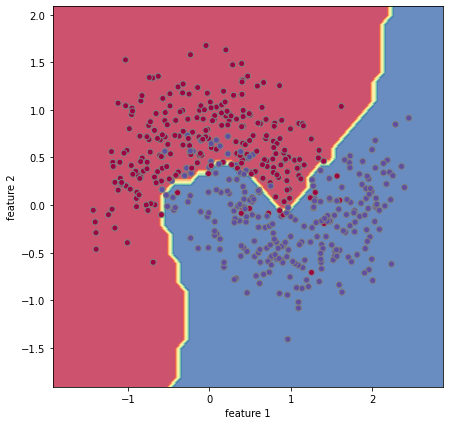

In [12]:
f1, f2 = 0, 1

plt.figure(figsize=(7, 7))

cm = plt.cm.Spectral

h = .1
x_min, x_max = X[:, f1].min() - .5, X[:, f1].max() + .5
y_min, y_max = X[:, f2].min() - .5, X[:, f2].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

gamma = 10.0
clf = SVC(C=1.0, kernel=lambda a, b: np.exp(-gamma*np.sum((a-b)**2)))
clf.fit(X[:, [f1, f2]], y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

plt.scatter(X[:, f1], X[:, f2], c=y, cmap=cm, edgecolor="grey")

plt.xlabel(f"feature {f1+1}")
plt.ylabel(f"feature {f2+1}")
plt.show()